<a href="INSERT_colab_R_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1.b
Sample points according to the true distribution and visualize the KLD for different parameter settings of
the Gaussian distribution (including the optimal one if available)

## Sampling from a Binomial Distribution

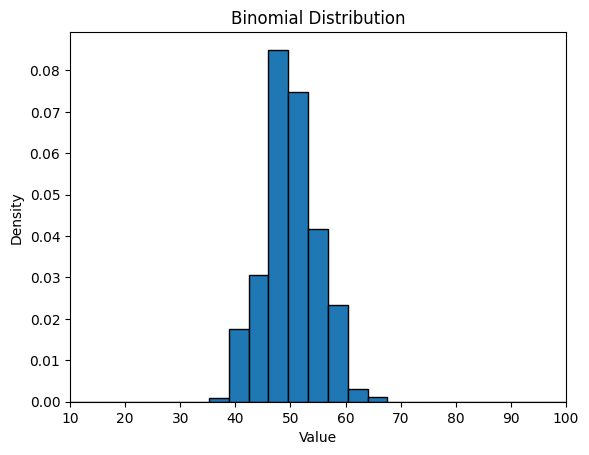

In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# you may need to run:
# pip/conda install numpy==1.26.4 matplotlib==3.8.4 scipy==1.13.0

# parameters
num_points = 1000  # number of points to sample
n = 100            # number of trials
p = 0.5            # probability of success

# fixing the seed for reproducibility
np.random.seed(42)

X = np.random.binomial(n=n, p=p, size=num_points)

# plotting
xlim_from = 10
xlim_to = 100
num_breaks = 25

plt.hist(
    X,
    bins=num_breaks,
    range=(xlim_from, xlim_to),
    density=True,
    edgecolor='black'
)
plt.title("Binomial Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(xlim_from, xlim_to)
plt.show()

## Various Gaussian distributions

In [9]:
true_exp = n * p 
true_variance = n * p * (1 - p) 
true_sd = np.sqrt(true_variance) 

# define different Normal density functions
normal_optimal = lambda x: norm.pdf(x, loc=true_exp, scale=true_sd)
normal_shift_left = lambda x: norm.pdf(x, loc=true_exp - 10, scale=true_sd)
normal_scale_increase = lambda x: norm.pdf(x, loc=true_exp, scale=true_sd * 2)
normal_shift_right_scale_decrease = lambda x: norm.pdf(x, loc=true_exp + 20, 
                                                       scale=p * (1 - p))


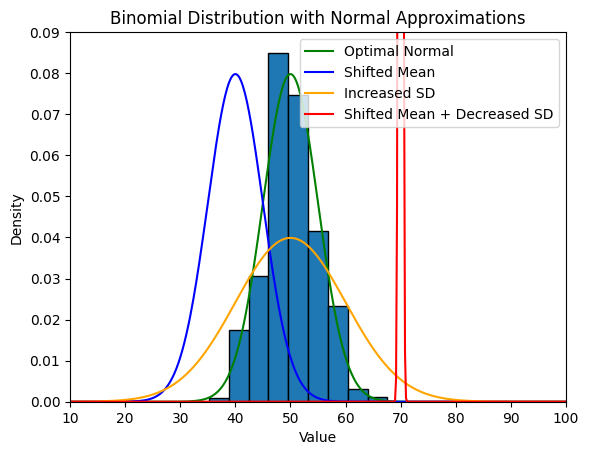

In [20]:
plt.hist(
    X,
    bins=num_breaks,
    range=(xlim_from, xlim_to),
    density=True,
    edgecolor='black'
)

# Create an array of x values for the curves
x_vals = np.linspace(xlim_from, xlim_to, 500)

# Overlay the Normal density curves
plt.plot(x_vals, normal_optimal(x_vals), color='green', label="Optimal Normal")
plt.plot(x_vals, normal_shift_left(x_vals), color='blue', label="Shifted Mean")
plt.plot(x_vals, normal_scale_increase(x_vals), color='orange', label="Increased SD")
plt.plot(x_vals, normal_shift_right_scale_decrease(x_vals), color='red', label="Shifted Mean + Decreased SD")

# Labels and title
plt.title("Binomial Distribution with Normal Approximations")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(xlim_from, xlim_to)
plt.ylim(0, 0.09)

plt.legend()
plt.show()

## KL divergence values
For these distributions, we get the following KL divergence values (up to an additive constant):

$$
D_{KL}(f||q) = c_3 + 0.5 \log \sigma^2 + \frac{1}{2\sigma^2} (\text{Var}_f(X) + (np-\mu)^2))
$$

In [23]:
# define the KL divergence function
def kld_value(mu, sigma2):
    return 0.5 * np.log(sigma2) + \
           0.5 * (true_variance + (true_exp - mu)**2) / sigma2

# compute and print the four KLD values
optimal_green = kld_value(true_exp, true_variance)
print(f"Optimal Normal (green): {optimal_green:.2f}")

shift_blue = kld_value(true_exp - 10, true_variance)
print(f"Shifted Mean (blue): {shift_blue:.2f}")

scale_increase_orange = kld_value(true_exp, true_variance * 4)
print(f"Increased SD (orange): {scale_increase_orange:.2f}")

right_scale_decrease_red = kld_value(true_exp + 20, (p * (1 - p))**2)
print(f"Shifted Mean + Decreased SD (red): {right_scale_decrease_red:.2f}")


Optimal Normal (green): 2.11
Shifted Mean (blue): 4.11
Increased SD (orange): 2.43
Shifted Mean + Decreased SD (red): 3398.61


# Conclusion (not sure if this is worth including)
KL divergence values replicate the misspecification of our distributions. Optimally specifed Gaussian produced the lowest value. Changing the mean and/or variance resulted in an increased KL divergance values

# Exercise 1.c
Since we are now required to calculate the exact KLD values, we would also have to calculate $\mathbb{E}_f(\log f(X))$, which is somewhat more difficult. If you search the internet for a solution ($\rightarrow$ "entropy of a binomial distribution"), you will find an approximate solution using the de-Moivre-Laplace theorem. Alternatively, we could make use of the central limit theorem, but then we would just approximate $f$ with a normal distribution with $\mu = np$ and $\sigma^2 = np(1-p)$, which would give us a constant KLD of zero (the very same happens if you use the first approximation using the de-Moivre-Laplace-theorem). We here instead will approximate the expectation using a large sample from the true underlying distribution:
$$
D_{KL}(f||q) \approx \frac{1}{B} \sum_{b=1}^B [\log f(X) - \log q(X|\mu = np, \sigma^2 = np(1-p))]
$$



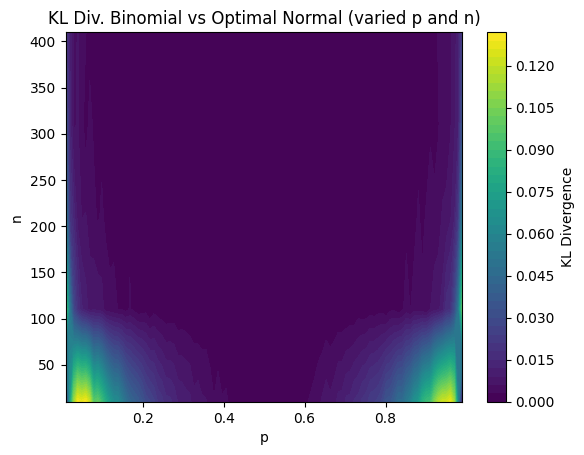

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from matplotlib.colors import LinearSegmentedColormap

p_seq = np.linspace(0.01, 0.99, 100)
n_seq = np.arange(10, 501, 100)
B = 10_000

# approximate KL divergence via sampling
def kld_value_approx(n, p):
    # sample a large number of data points from true distribution
    x = np.random.binomial(n=n, p=p, size=B)
    
    # log PMFs
    binom_log_pmf = binom.logpmf(x, n=n, p=p)
    normal_log_pdf = norm.logpdf(x, loc=n*p, scale=np.sqrt(n*p*(1-p)))
    
    # approximate the mean; threshold values to 0 if < 0 due to the approximation
    return max(np.nanmean(binom_log_pmf - normal_log_pdf), 0)

# KLD for each combination of n and p
kld_val = np.array([
    [kld_value_approx(n, p) for p in p_seq]
    for n in n_seq
])

plt.figure()
plt.contourf(p_seq, n_seq, kld_val, levels=50)
plt.colorbar(label='KL Divergence')
plt.xlabel('p')
plt.ylabel('n')
plt.title('KL Div. Binomial vs Optimal Normal (varied p and n)')
plt.show()
